In [ ]:
from random import gauss, seed, randrange
import random
import multiprocessing as mp
from os import cpu_count
import json
from collections import namedtuple
from math import sqrt, fabs

import pandas as pd
import gym
import numpy as np
from datetime import datetime, timedelta

from IPython.display import clear_output
import pdb
from matplotlib import pyplot as plt

In [6]:
"""Training the agent"""


# learner hyperparameters

def relative_differential():
    sign = random.choice([-1.0, 1.0])
    ratio = randrange(1.0, 30.0)/100.
    #multiplier = 1+(ratio*sign)
    return ratio, sign


def dynamic_alpha():
    
    alpha_metaparams = {
        "initial": randrange(5.0, 25.0, 1.0)/100.,
        "minimum": 0.01,
        "maximum": 0.3,
        "steps_differential": relative_differential(),
        "reward_differential": relative_differential(),
        "penalties_differential": relative_differential(),
    }
    return alpha_metaparams

def dynamic_gamma():
    
    gamma_metaparams = {
        "initial": randrange(60.0, 95.0, 1.0)/100.,
        "minimum": 0.5,
        "maximum": 0.99,
        "steps_differential": relative_differential(),
        "reward_differential": relative_differential(),
        "penalties_differential": relative_differential(),
    }
    return gamma_metaparams

def dynamic_epsilon():
    
    epsilon_metaparams = {
        "initial": randrange(5.0, 40.0, 1.0)/100.,
        "minimum": 0.01,
        "maximum": 0.5,
        "steps_differential": relative_differential(),
        "reward_differential": relative_differential(),
        "penalties_differential": relative_differential(),
    }
    return epsilon_metaparams



def update_running_average(counter_list, averages_list, learning_interval):
    if (len(counter_list) < 1000):
        average = sum(counter_list)/len(counter_list)
    else:
        average = sum(counter_list[-1000:])/len(counter_list[-1000:])
    averages_list.append(average)
    return



def metric_relative_differential(averages_list, learning_interval):
    latest_running_avg = averages_list[-1]
    prev_running_avg = averages_list[-learning_interval]
    denom = (latest_running_avg+prev_running_avg)/2.0
    try:
        if denom == 0:
            return 0, 1
        else:
            relative_differential = (latest_running_avg-prev_running_avg)/denom
            sign_rel_diff = relative_differential/fabs(relative_differential)
            return relative_differential, sign_rel_diff
    except ZeroDivisionError:
        return 0.0, 1



def update_hparam(hparam, hparam_metaparams,
                  rewards_r_avg,
                  penalties_r_avg,
                  steps_r_avg,
                  learning_interval):
 
    rewards_rel_diff, rewards_diff_sign = metric_relative_differential(rewards_r_avg, learning_interval)
    penalties_rel_diff, penalties_diff_sign = metric_relative_differential(penalties_r_avg, learning_interval)
    steps_rel_diff, steps_diff_sign = metric_relative_differential(steps_r_avg, learning_interval)

    h_rewards_ratio = hparam_metaparams['reward_differential'][0]
    h_rewards_sign = hparam_metaparams['reward_differential'][1]

    h_penalties_ratio = hparam_metaparams['penalties_differential'][0]
    h_penalties_sign = hparam_metaparams['penalties_differential'][1]

    h_steps_ratio = hparam_metaparams['steps_differential'][0]
    h_steps_sign = hparam_metaparams['steps_differential'][1]
    
    del_sq_rewards = (h_rewards_ratio*rewards_rel_diff)**2
    del_sq_penalties = (h_penalties_ratio*penalties_rel_diff)**2
    del_sq_steps = (h_steps_ratio*steps_rel_diff)**2
    
    
    try:
        sign_del = ((h_steps_sign * steps_diff_sign * del_sq_steps + 
                     h_rewards_sign * rewards_diff_sign * del_sq_rewards + 
                     h_penalties_sign * penalties_diff_sign * del_sq_penalties)/
                     fabs(h_steps_sign * steps_diff_sign * del_sq_steps + 
                          h_rewards_sign * rewards_diff_sign * del_sq_rewards + 
                          h_penalties_sign * penalties_diff_sign * del_sq_penalties))

        mag_del = sqrt(del_sq_rewards + del_sq_penalties + del_sq_steps)
        
        del_ = sign_del*mag_del
        
    except ZeroDivisionError: # it hypothetically could happen
        return hparam
    
    
    calculated = hparam * (1 + del_)

    if calculated < hparam_metaparams['minimum']:
        return hparam_metaparams['minimum']
    elif calculated > hparam_metaparams['maximum']:
        return hparam_metaparams['maximum']
    else:
        return calculated
    
    
    
def convergence_check(running_average_list, convergence_interval=100):
    if metric_relative_differential(running_average_list, convergence_interval) < 0.01:
        return True
    return False




# environmental reward modifiers

def make_chaos_level():
    chaos_level = randrange(start=0.0, stop=100.0, step=1.0)/100
    return chaos_level


def chaos_mod(chaos_level):
    if (random.uniform(0,1) < chaos_level):
        mod = gauss(0.0, chaos_level)
    else:
        mod = 0
    return mod


def calculate_reward(base_reward, chaos_level):
    percent_diff = chaos_mod(chaos_level)
    adjusted_reward = base_reward*(1+percent_diff)
    return adjusted_reward


def train_dynamic_learner(chaos=True):
    
    start = dt.now()
    
    epoch_count = 60000
    learning_interval = random.choice([250, 500, 1000])
    
    env = gym.make("Taxi-v3").env
    
    #Initialize Q table
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    
    alpha_metaparams = dynamic_alpha()
    gamma_metaparams = dynamic_gamma()
    epsilon_metaparams = dynamic_epsilon()
    
    alpha = alpha_metaparams["initial"]
    gamma = gamma_metaparams["initial"]
    epsilon = epsilon_metaparams["initial"]
        
    alpha_by_epoch = []
    gamma_by_epoch = []
    epsilon_by_epoch = []
    
    if chaos:
        chaos_level = make_chaos_level()
    else:
        chaos_level = 0.0
        
    
    
    # For plotting metrics
    epoch_step_counts = []
    base_reward_totals = []
    custom_reward_totals = []
    penalty_counts = []
    
    epoch_step_count_running_average = []
    base_reward_running_average = []
    custom_reward_running_average = []
    penalty_running_average = []
    
    
    metadata = {
        "alpha_metaparams": alpha_metaparams,
        "gamma_metaparams": gamma_metaparams,
        "epsilon_metaparams": epsilon_metaparams,
        "alpha_by_epoch": alpha_by_epoch,
        "gamma_by_epoch": gamma_by_epoch,
        "epsilon_by_epoch": epsilon_by_epoch,
        "chaos_level": chaos_level,
        "epoch_step_counts": epoch_step_counts,
        "base_reward_totals": base_reward_totals,
        "custom_reward_totals": custom_reward_totals,
        "penalty_counts": penalty_counts,
        "learning_interval": learning_interval
        }
    
    
    for i in range(1, (epoch_count + 1)):
        
        
        state = env.reset()

        epochs, penalties, reward = 0, 0, 0
        
        step_count = 0
        net_base_reward = 0
        net_custom_reward = 0
        
        alpha_by_epoch.append(alpha)
        gamma_by_epoch.append(gamma)
        epsilon_by_epoch.append(epsilon)
        
        done = False

        while not done:
            
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action)
            

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
            
            custom_reward = calculate_reward(reward, chaos_level)

            new_value = (1 - alpha) * old_value + alpha * (custom_reward + gamma * next_max)

            q_table[state, action] = new_value


            if reward == -10:
                penalties += 1

            net_base_reward += reward
            net_custom_reward += custom_reward
            step_count += 1
            
            state = next_state
            
            
        # update params and hparams for next epoch
        base_reward_totals.append(net_base_reward)
        custom_reward_totals.append(net_custom_reward)
        epoch_step_counts.append(step_count)
        penalty_counts.append(penalties)
        
        update_running_average(base_reward_totals, base_reward_running_average, learning_interval)
        update_running_average(custom_reward_totals, custom_reward_running_average, learning_interval)
        update_running_average(epoch_step_counts, epoch_step_count_running_average, learning_interval)
        update_running_average(penalty_counts, penalty_running_average, learning_interval)
        
        latest = dt.now()
        
        training_time = latest-start
        
        metadata["training_time"] = str(training_time)
        
        #if (training_time > timedelta(minutes=10)):
        #    return None
        

        if i%learning_interval==0:
            alpha = update_hparam(alpha, alpha_metaparams, 
                                  custom_reward_running_average,
                                  penalty_running_average,
                                  epoch_step_count_running_average,
                                  learning_interval)

            gamma = update_hparam(gamma, gamma_metaparams, 
                                  custom_reward_running_average,
                                  penalty_running_average,
                                  epoch_step_count_running_average,
                                  learning_interval)
            
            epsilon = update_hparam(epsilon, epsilon_metaparams, 
                                    custom_reward_running_average,
                                    penalty_running_average,
                                    epoch_step_count_running_average,
                                    learning_interval) 
            
    
        
        
        if i%10000==0:
            #clear_output(wait=True)
            print(f"Episode: {i}")
            print(metadata["training_time"])

            """
            print("latest step count: " + str(epoch_step_counts[-1]))
            print("latest base reward: " + str(base_reward_totals[-1]))
            print("latest penalty running average: " + str(penalty_running_average[-1]))
            print("initial alpha: " + str(alpha_metaparams["initial"]))
            print("initial gamma: " + str(gamma_metaparams["initial"]))
            print("initial epsilon: " + str(epsilon_metaparams["initial"]))
            print("alpha: " + str(alpha))
            print("gamma: " + str(gamma))
            print("epsilon: " + str(epsilon))
            print(len(metadata["epoch_step_counts"]))
            print(len(metadata["alpha_by_epoch"]))
            print(len(penalty_running_average))     # note: not a key, just a name
            print(metadata["training_time"])
            #print(convergence_check(penalty_running_average))
            #print(convergence_check(base_reward_running_average))
            """
            
        
            """
        if i%1000==0:
            if i > 15000:
                if convergence_check(penalty_running_average) == True:
                    return metadata

                if convergence_check(base_reward_running_average) == True:
                    return metadata
                    
        """
    
    return metadata


    
def dynamic_sim_no_chaos():
    result = train_dynamic_learner(chaos=False)
    filename = "./simulation_data/dynamic_learners_no_chaos.json"
    return result, filename


def dynamic_sim_with_chaos():
    result = train_dynamic_learner(chaos=True)
    filename = "./simulation_data/dynamic_learners_with_chaos.json"
    return result, filename

from datetime import datetime as dt
print(dt.now())


"""
if __name__ == "__main__":
    start = datetime.now()
    #cpus = cpu_count() - 1
    procs = 4
    N = 500
    
    print(start)
    print("Starting {} linear sims in {} processes.".format(N, procs))
    with mp.Pool(processes=procs) as pool:
        
        for i in range(N):
        
            result, filename = pool.apply_async(dynamic_sim_no_chaos).get() 
            with open(filename, "a") as dest:
                dest.write(json.dumps(result) + '\n')

                
            result, filename = pool.apply_async(dynamic_sim_with_chaos).get()
            with open(filename, "a") as dest:
                dest.write(json.dumps(result) + '\n')

        
    print("Finishing sims")
    end = datetime.now()
    print("{} sims run in {}.".format(str(2*N), str(end-start)))
    
from datetime import datetime as dt
start = dt.now()
print("Start: " + str(start))    """

2021-12-29 23:24:20.953189


'\nif __name__ == "__main__":\n    start = datetime.now()\n    #cpus = cpu_count() - 1\n    procs = 4\n    N = 500\n    \n    print(start)\n    print("Starting {} linear sims in {} processes.".format(N, procs))\n    with mp.Pool(processes=procs) as pool:\n        \n        for i in range(N):\n        \n            result, filename = pool.apply_async(dynamic_sim_no_chaos).get() \n            with open(filename, "a") as dest:\n                dest.write(json.dumps(result) + \'\n\')\n\n                \n            result, filename = pool.apply_async(dynamic_sim_with_chaos).get()\n            with open(filename, "a") as dest:\n                dest.write(json.dumps(result) + \'\n\')\n\n        \n    print("Finishing sims")\n    end = datetime.now()\n    print("{} sims run in {}.".format(str(2*N), str(end-start)))\n    \nfrom datetime import datetime as dt\nstart = dt.now()\nprint("Start: " + str(start))    '

In [10]:

total=0
training_times = []
for phase in range(20):
    if total == 100:
        break
    clear_output()
    print(phase+1)
    print(training_times)
    for i in range(5):
        print(i+1)
        print(dt.now())
        result, filename = dynamic_sim_no_chaos()
        if result:
            training_times.append(result["training_time"])
            print("saving {}:{}".format((phase+1),(i+1)))
            with open(filename, "a") as dest:
                dest.write(json.dumps(result) + '\n')
            total += 1


1
[]
1
2021-12-29 23:27:09.102064
Episode: 10000
0:00:07.428384
Episode: 20000
0:00:13.906011
Episode: 30000
0:00:20.595304
Episode: 40000
0:00:27.596288
Episode: 50000
0:00:34.032437
Episode: 60000
0:00:40.346078
saving 1:1
2
2021-12-29 23:27:49.586348
Episode: 10000
0:00:10.960414
Episode: 20000
0:07:18.966085


KeyboardInterrupt: 

In [29]:
training_times

['0:01:17.740658',
 '0:00:21.379215',
 '0:01:33.978135',
 '0:00:47.733775',
 '0:00:53.232075',
 '0:00:51.834481']

In [3]:
from datetime import datetime as dt
start = dt.now()
print("Start: " + str(start))

testing_convergence = train_dynamic_learner(chaos=True)

Episode: 60000
latest step count: 15
latest base reward: 6
latest penalty running average: 0.045
initial alpha: 0.15
initial gamma: 0.62
initial epsilon: 0.34
alpha: 0.2504263313491801
gamma: 0.8229400872602297
epsilon: 0.011117595581687807
60000
60000
60000


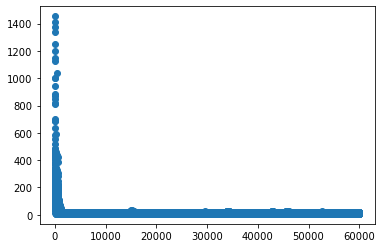

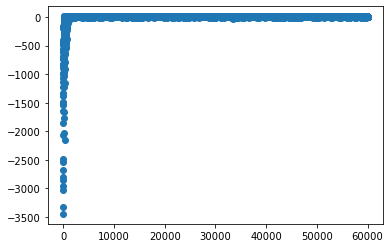

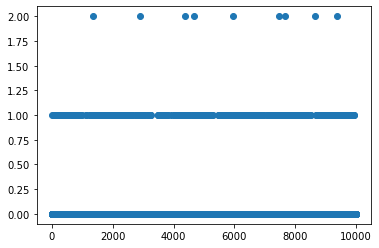

In [4]:
plt.scatter(range(60000), testing_convergence["epoch_step_counts"])
plt.show()

plt.scatter(range(60000), testing_convergence["penalty_counts"])
plt.show()

plt.scatter(range(60000), testing_convergence["base_reward_totals"])
plt.show()

plt.scatter(range(5000), testing_convergence["custom_reward_totals"][0:5000])
plt.show()

plt.scatter(range(10000), testing_convergence["penalty_counts"][-10000:])
plt.show()

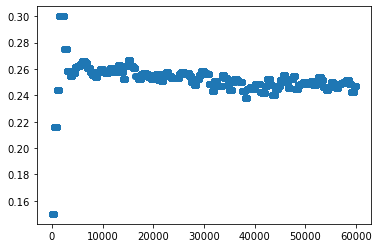

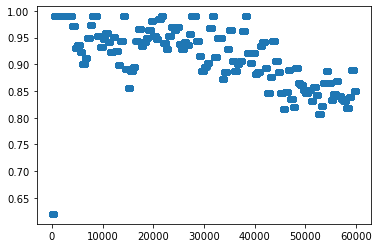

In [5]:
plt.scatter(range(60000), testing_convergence["alpha_by_epoch"])
plt.show()

plt.scatter(range(60000), testing_convergence["epsilon_by_epoch"])
plt.show()

plt.scatter(range(60000), testing_convergence["gamma_by_epoch"])
plt.show()

In [6]:
from datetime import datetime as dt
start = dt.now()
print("Start: " + str(start))

meta = train_dynamic_learner()

end = dt.now()
print(end-start)

Episode: 60000
latest step count: 16
latest base reward: 5
latest penalty running average: 0.536
initial alpha: 0.17
initial gamma: 0.66
initial epsilon: 0.37
alpha: 0.01203896514870245
gamma: 0.5326869660923479
epsilon: 0.015159876436171841
60000
60000
60000
0:02:29.725303


In [7]:
print(len(meta["epoch_step_counts"]))
print(len(meta["alpha_by_epoch"]))
#print(len(meta["penalty_running_average"]))
dyn_learner_no_chaos = meta

60000
60000


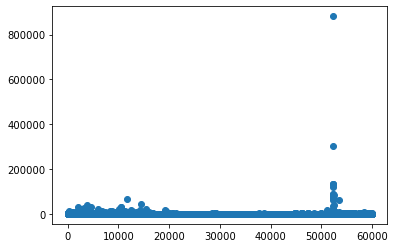

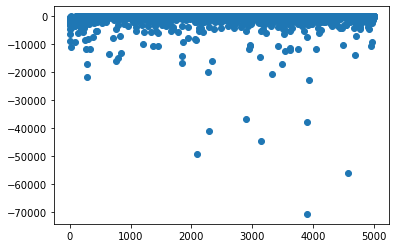

In [8]:
plt.scatter(range(60000), dyn_learner_no_chaos["epoch_step_counts"])
plt.show()

plt.scatter(range(60000), dyn_learner_no_chaos["penalty_counts"])
plt.show()

plt.scatter(range(60000), dyn_learner_no_chaos["base_reward_totals"])
plt.show()

plt.scatter(range(5000), dyn_learner_no_chaos["custom_reward_totals"][0:5000])
plt.show()

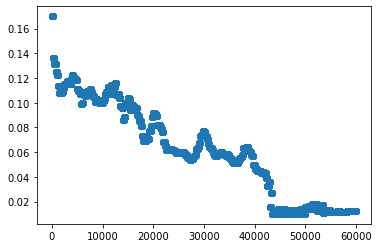

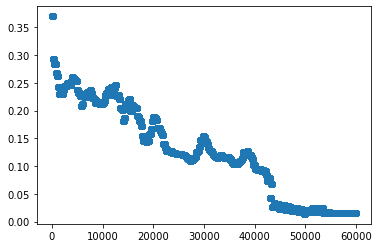

In [9]:
plt.scatter(range(60000), dyn_learner_no_chaos["alpha_by_epoch"])
plt.show()

plt.scatter(range(60000), dyn_learner_no_chaos["epsilon_by_epoch"])
plt.show()

plt.scatter(range(60000), dyn_learner_no_chaos["gamma_by_epoch"])
plt.show()

In [10]:
dyn_learner_with_chaos, filename = dynamic_sim_with_chaos()

len(dyn_learner_with_chaos["epoch_step_counts"])

Episode: 60000
latest step count: 20
latest base reward: -26
latest penalty running average: 1.3
initial alpha: 0.15
initial gamma: 0.89
initial epsilon: 0.33
alpha: 0.031896377224334936
gamma: 0.9688050748708704
epsilon: 0.23535705893734693
60000
60000
60000


60000

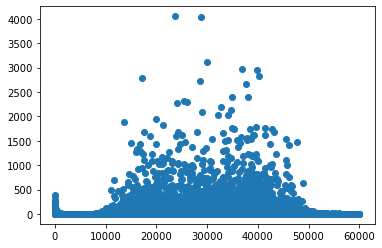

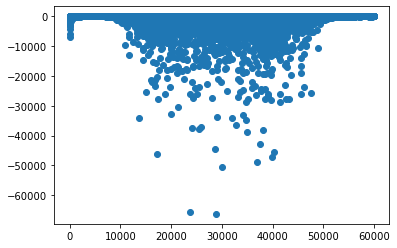

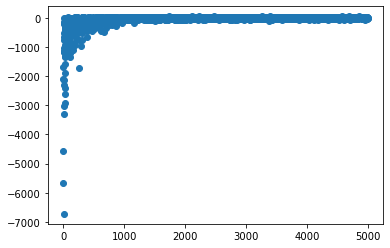

In [11]:
plt.scatter(range(60000), dyn_learner_with_chaos["epoch_step_counts"])
plt.show()

plt.scatter(range(60000), dyn_learner_with_chaos["penalty_counts"])
plt.show()

plt.scatter(range(60000), dyn_learner_with_chaos["base_reward_totals"])
plt.show()

plt.scatter(range(5000), dyn_learner_with_chaos["custom_reward_totals"][:5000])
plt.show()

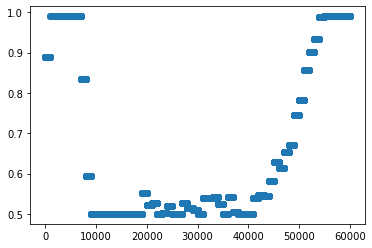

In [12]:
plt.scatter(range(60000), dyn_learner_with_chaos["alpha_by_epoch"])
plt.show()

plt.scatter(range(60000), dyn_learner_with_chaos["epsilon_by_epoch"])
plt.show()

plt.scatter(range(60000), dyn_learner_with_chaos["gamma_by_epoch"])
plt.show()

Episode: 60000
latest step count: 14
latest base reward: -2
latest penalty running average: 18.074
initial alpha: 0.2
initial gamma: 0.62
initial epsilon: 0.35
alpha: 0.25772199835585025
gamma: 0.6676482253402117
epsilon: 0.4054396290689108
60000
60000
60000


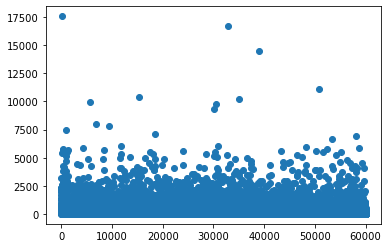

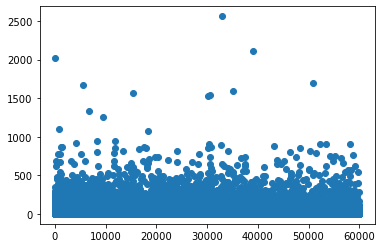

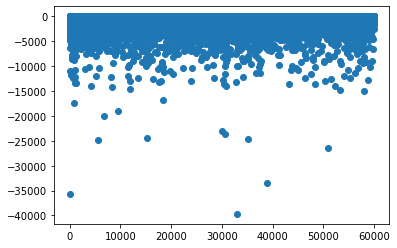

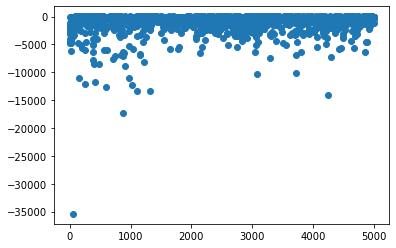

In [13]:
dyn_learner_with_chaos_b, filename = dynamic_sim_with_chaos()

plt.scatter(range(60000), dyn_learner_with_chaos_b["epoch_step_counts"])
plt.show()

plt.scatter(range(60000), dyn_learner_with_chaos_b["penalty_counts"])
plt.show()

plt.scatter(range(60000), dyn_learner_with_chaos_b["base_reward_totals"])
plt.show()

plt.scatter(range(5000), dyn_learner_with_chaos_b["custom_reward_totals"][0:5000])
plt.show()



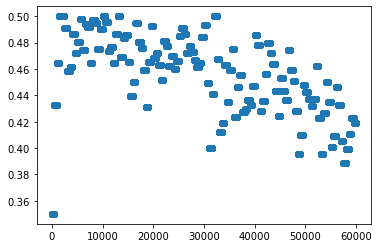

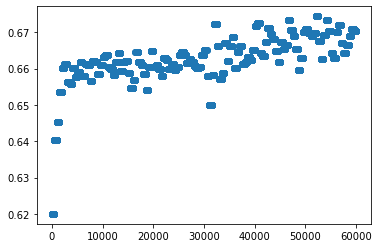

In [14]:
plt.scatter(range(60000), dyn_learner_with_chaos_b["alpha_by_epoch"])
plt.show()

plt.scatter(range(60000), dyn_learner_with_chaos_b["epsilon_by_epoch"])
plt.show()

plt.scatter(range(60000), dyn_learner_with_chaos_b["gamma_by_epoch"])
plt.show()


In [20]:
three_great_examples = [meta, dyn_learner_with_chaos, dyn_learner_with_chaos_b]

filename = "three_great_dynamic_examples.json"


for i in three_great_examples:
    with open(filename, "a") as dest:
        dest.write(json.dumps(i) + '\n')

In [18]:
another_with_chaos = train_dynamic_learner()

Episode: 60000
latest step count: 331
latest base reward: -310
latest penalty running average: 3.829
initial alpha: 0.15
initial gamma: 0.67
initial epsilon: 0.15
alpha: 0.01
gamma: 0.7127322147866274
epsilon: 0.017107525421156528
60000
60000
60000
0:06:37.854530


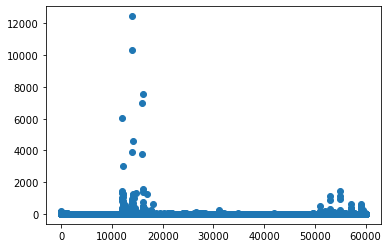

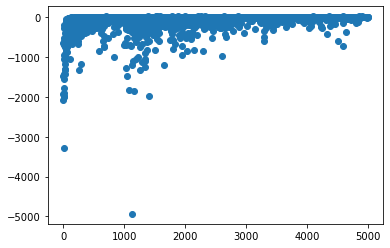

In [21]:
plt.scatter(range(60000), another_with_chaos["epoch_step_counts"])
plt.show()

plt.scatter(range(60000), another_with_chaos["penalty_counts"])
plt.show()

plt.scatter(range(60000), another_with_chaos["base_reward_totals"])
plt.show()

plt.scatter(range(5000), another_with_chaos["custom_reward_totals"][0:5000])
plt.show()

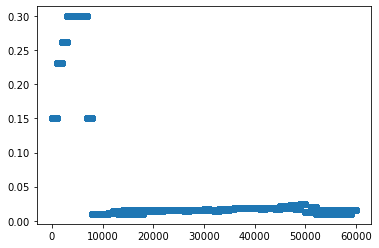

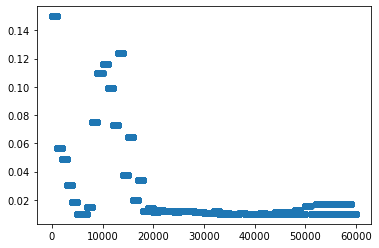

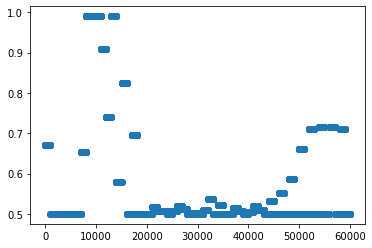

In [27]:
plt.scatter(range(60000), another_with_chaos["alpha_by_epoch"])
plt.show()

plt.scatter(range(60000), another_with_chaos["epsilon_by_epoch"])
plt.show()

plt.scatter(range(60000), another_with_chaos["gamma_by_epoch"])
plt.show()

In [25]:
another_with_chaos["training_time"] = str(another_with_chaos["training_time"])

with open(filename, "a") as dest:
    dest.write(json.dumps(another_with_chaos) + '\n')

Episode: 60000
latest step count: 12
latest base reward: 9
latest penalty running average: 0.402
initial alpha: 0.19
initial gamma: 0.62
initial epsilon: 0.05
alpha: 0.018472776667112174
gamma: 0.7912092629881116
epsilon: 0.09450054957560342
60000
60000
60000
0:00:38.823408


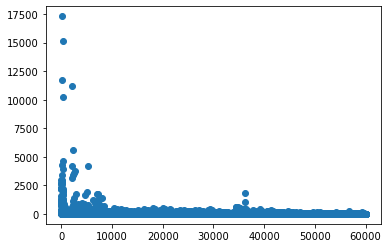

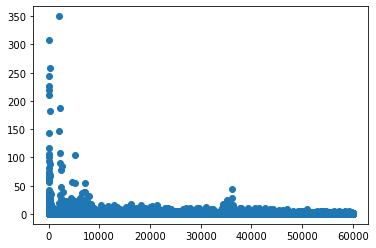

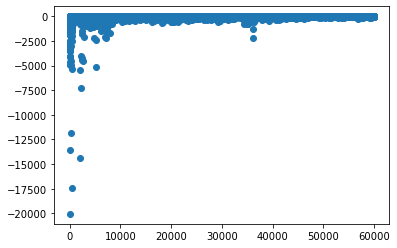

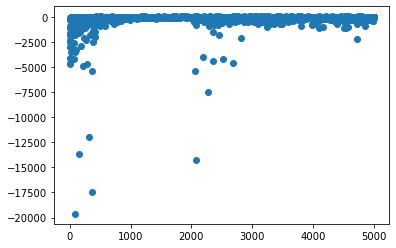

In [26]:
fifth = train_dynamic_learner()

plt.scatter(range(60000), fifth["epoch_step_counts"])
plt.show()

plt.scatter(range(60000), fifth["penalty_counts"])
plt.show()

plt.scatter(range(60000), fifth["base_reward_totals"])
plt.show()

plt.scatter(range(5000), fifth["custom_reward_totals"][0:5000])
plt.show()

In [1]:
plt.scatter(range(60000), fifth["alpha_by_epoch"])
plt.show()

plt.scatter(range(60000), fifth["epsilon_by_epoch"])
plt.show()

plt.scatter(range(60000), fifth["gamma_by_epoch"])
plt.show()

NameError: name 'plt' is not defined

In [29]:
with open(filename, "a") as dest:
    dest.write(json.dumps(fifth) + '\n')

In [32]:
sims = [train_dynamic_learner() for i in range(25)]

Episode: 42000
latest step count: 29
latest base reward: -8
latest penalty running average: 82.915
initial alpha: 0.11
initial gamma: 0.79
initial epsilon: 0.34
alpha: 0.014128247028527722
gamma: 0.7501837334176604
epsilon: 0.01715760192801835
42000
42000
42000
0:37:22.097856


KeyboardInterrupt: 

Episode: 43000
latest step count: 56
latest base reward: -44
latest penalty running average: 0.287
initial alpha: 0.06
initial gamma: 0.76
initial epsilon: 0.26
alpha: 0.015158982766559293
gamma: 0.5
epsilon: 0.016361775001391927
43000
43000
43000
0:12:10.345834


KeyboardInterrupt: 

NameError: name 'sims' is not defined

0

In [6]:
timedelta(minutes=10)

datetime.timedelta(seconds=600)